# Imports


In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
#import squarify
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from collections import defaultdict

# Load Dataset

In [2]:
# # Install dependencies if needed:
# # pip install kagglehub[pandas-datasets]

# import kagglehub
# from kagglehub import KaggleDatasetAdapter
# import pandas as pd

# # Specify the CSV file you want from the dataset
# file_path = "2019-Oct.csv"  # You can change to another file, like '2019-Nov.csv'

# # Load only the first 1,000,000 rows using pandas_kwargs
# df = kagglehub.load_dataset(
#     KaggleDatasetAdapter.PANDAS,
#     "mkechinov/ecommerce-behavior-data-from-multi-category-store",
#     file_path,
#     pandas_kwargs={"nrows": 2000000}
# )

# # Show the first 5 records
# print("First 5 records:")
# print(df.head())


In [3]:
file_path = 'C:\\Users\\malak\\source\\repos\\Sales-Customer-Behavior-Analysis\\Dataset\\2019-Oct.csv'
target_col = 'event_type'
sample_size = 10_000_000

In [4]:
# Step 1: Count the total number of rows (excluding header)
with open(file_path, 'r', encoding='utf-8') as f:
    n_rows = sum(1 for line in f) - 1  # minus 1 for header

In [5]:
# Step 2: Load only the 'event_type' column to get class distribution
event_types = pd.read_csv(file_path, usecols=[target_col])[target_col]

In [6]:
# Step 3: Get indices for each class
indices_per_class = defaultdict(list)
for idx, label in enumerate(event_types):
    indices_per_class[label].append(idx)

In [7]:
# Step 4: Calculate how many samples per class based on the smallest class size
num_classes = len(indices_per_class)  # Number of unique event types
min_class_size = min(len(indices) for indices in indices_per_class.values())  # Fewest available samples
samples_per_class = min(min_class_size, sample_size // num_classes)

In [8]:
# Step 5: Randomly sample indices for each class
balanced_indices = []
for label, indices in indices_per_class.items():
    if len(indices) < samples_per_class:
        raise ValueError(f"Not enough samples for class '{label}'")
    balanced_indices.extend(random.sample(indices, samples_per_class))
    random.shuffle(balanced_indices)


In [9]:
# Step 6: Prepare skip set (fast)
all_indices = set(range(1, n_rows + 1))  # line numbers excluding header
keep_indices = set(i + 1 for i in balanced_indices)  # shift by 1 for header
skip_set = all_indices - keep_indices

In [10]:
# Step 7: Read only sampled rows
df_balanced = pd.read_csv(file_path, skiprows=lambda x: x in skip_set)

In [11]:
# Step 8: Confirm class balance
print(df_balanced[target_col].value_counts())

event_type
view        742849
purchase    742849
cart        742849
Name: count, dtype: int64


In [12]:
df = df_balanced

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228547 entries, 0 to 2228546
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 153.0+ MB


In [14]:
df.shape

(2228547, 9)

# Preprocessing


In [15]:
df.isnull().sum().sum()

682551

In [16]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:13 UTC,view,3900746,2053013552326770905,appliances.environment.water_heater,haier,102.38,555444559,98b88fa0-d8fa-4b9d-8a71-3dd403afab85
1,2019-10-01 00:00:36 UTC,view,12712064,2053013553559896355,NaN,triangle,30.89,515454339,828dbd8e-8683-409b-aef6-6a94ac983b45
2,2019-10-01 00:01:21 UTC,view,28708392,2053013565069067197,apparel.shoes.keds,strobbs,31.92,555447570,99877fbe-d5a8-475e-a662-66bc9d29b6f8
3,2019-10-01 00:01:26 UTC,view,15100008,2053013557024391671,NaN,bts,488.82,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
4,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564


In [17]:
df.duplicated().sum()

19867

In [18]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Fill missing category_code and brand
df['category_code'] = df['category_code'].fillna(df['category_code'].mode()[0])
df['brand'] = df['brand'].fillna(df['brand'].mode()[0])


In [19]:
print(df['event_type'].value_counts())
print(df['event_type'].nunique())
df['event_type'].unique().tolist()

event_type
view        742849
purchase    742773
cart        723058
Name: count, dtype: int64
3


['view', 'purchase', 'cart']

In [20]:
print(df['event_type'].isnull().sum())

0


In [21]:
le = LabelEncoder()
df['event_type'] = le.fit_transform(df['event_type'])
print(le.classes_)

['cart' 'purchase' 'view']


In [22]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:13 UTC,2,3900746,2053013552326770905,appliances.environment.water_heater,haier,102.38,555444559,98b88fa0-d8fa-4b9d-8a71-3dd403afab85
1,2019-10-01 00:00:36 UTC,2,12712064,2053013553559896355,electronics.smartphone,triangle,30.89,515454339,828dbd8e-8683-409b-aef6-6a94ac983b45
2,2019-10-01 00:01:21 UTC,2,28708392,2053013565069067197,apparel.shoes.keds,strobbs,31.92,555447570,99877fbe-d5a8-475e-a662-66bc9d29b6f8
3,2019-10-01 00:01:26 UTC,2,15100008,2053013557024391671,electronics.smartphone,bts,488.82,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
4,2019-10-01 00:02:14 UTC,1,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564


In [23]:
print(df['brand'].value_counts())
print(df['brand'].nunique())
print("___")
print(df['category_code'].value_counts())
print(df['category_code'].nunique())

brand
samsung        678922
apple          375020
xiaomi         192000
huawei          75742
oppo            34768
                ...  
elleci              1
dyflon              1
karadium            1
omnio               1
daneildesch         1
Name: count, Length: 2721, dtype: int64
2721
___
category_code
electronics.smartphone          1456914
electronics.audio.headphone       89148
electronics.video.tv              69076
electronics.clocks                57220
appliances.kitchen.washer         48178
                                 ...   
construction.tools.soldering         11
apparel.jacket                       11
auto.accessories.anti_freeze          9
apparel.shorts                        6
country_yard.furniture.bench          3
Name: count, Length: 126, dtype: int64
126


In [24]:
df.brand.isnull().sum()

0

In [25]:
df['category_code'] = df['category_code'].fillna(df['category_code'].mode()[0])
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     1
dtype: int64

In [26]:
encoder = ce.BinaryEncoder(cols=['category_code', 'brand'])
df_encoded = encoder.fit_transform(df[['category_code', 'brand']])
df = pd.concat([df.drop(['category_code', 'brand'], axis=1), df_encoded], axis=1)
print(df.head())

                event_time  event_type  product_id          category_id  \
0  2019-10-01 00:00:13 UTC           2     3900746  2053013552326770905   
1  2019-10-01 00:00:36 UTC           2    12712064  2053013553559896355   
2  2019-10-01 00:01:21 UTC           2    28708392  2053013565069067197   
3  2019-10-01 00:01:26 UTC           2    15100008  2053013557024391671   
4  2019-10-01 00:02:14 UTC           1     1004856  2053013555631882655   

    price    user_id                          user_session  category_code_0  \
0  102.38  555444559  98b88fa0-d8fa-4b9d-8a71-3dd403afab85                0   
1   30.89  515454339  828dbd8e-8683-409b-aef6-6a94ac983b45                0   
2   31.92  555447570  99877fbe-d5a8-475e-a662-66bc9d29b6f8                0   
3  488.82  519107250  566511c2-e2e3-422b-b695-cf8e6e792ca8                0   
4  130.76  543272936  8187d148-3c41-46d4-b0c0-9c08cd9dc564                0   

   category_code_1  category_code_2  ...  brand_2  brand_3  brand_4  brand

In [27]:
df.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:13 UTC,2,3900746,2053013552326770905,102.38,555444559,98b88fa0-d8fa-4b9d-8a71-3dd403afab85,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:36 UTC,2,12712064,2053013553559896355,30.89,515454339,828dbd8e-8683-409b-aef6-6a94ac983b45,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:01:21 UTC,2,28708392,2053013565069067197,31.92,555447570,99877fbe-d5a8-475e-a662-66bc9d29b6f8,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:01:26 UTC,2,15100008,2053013557024391671,488.82,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:02:14 UTC,1,1004856,2053013555631882655,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [29]:
df.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:13 UTC,2,3900746,2053013552326770905,102.38,555444559,98b88fa0-d8fa-4b9d-8a71-3dd403afab85,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:36 UTC,2,12712064,2053013553559896355,30.89,515454339,828dbd8e-8683-409b-aef6-6a94ac983b45,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:01:21 UTC,2,28708392,2053013565069067197,31.92,555447570,99877fbe-d5a8-475e-a662-66bc9d29b6f8,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:01:26 UTC,2,15100008,2053013557024391671,488.82,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:02:14 UTC,1,1004856,2053013555631882655,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [31]:
df.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:13 UTC,2,3900746,2053013552326770905,102.38,555444559,98b88fa0-d8fa-4b9d-8a71-3dd403afab85,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:36 UTC,2,12712064,2053013553559896355,30.89,515454339,828dbd8e-8683-409b-aef6-6a94ac983b45,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:01:21 UTC,2,28708392,2053013565069067197,31.92,555447570,99877fbe-d5a8-475e-a662-66bc9d29b6f8,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:01:26 UTC,2,15100008,2053013557024391671,488.82,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:02:14 UTC,1,1004856,2053013555631882655,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [32]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


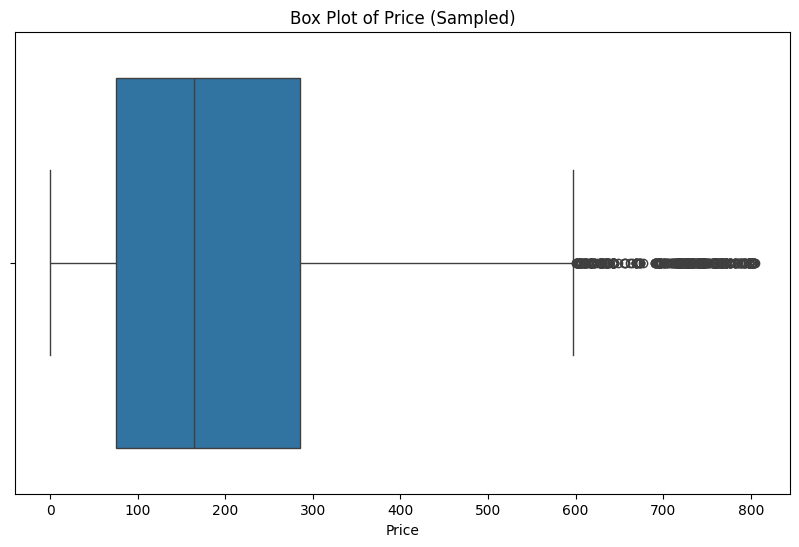

In [33]:
# Sample 10,000 rows from the dataset
sample_df = df['price'].sample(n=10000, random_state=42)

plt.figure(figsize=(10, 6))
sns.boxplot(x=sample_df)
plt.title('Box Plot of Price (Sampled)')
plt.xlabel('Price')
plt.show()

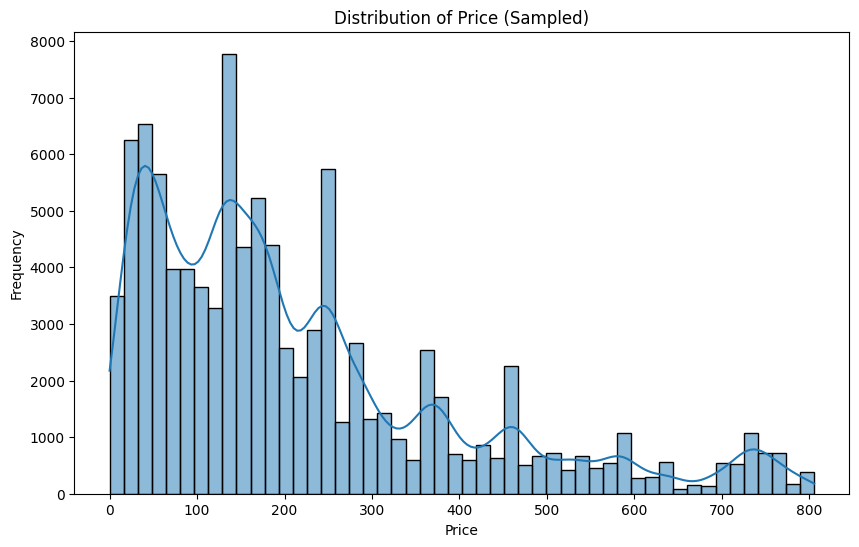

In [34]:
# Sample 100,000 rows (adjust size based on available memory)
sample = df['price'].sample(n=100000, random_state=42)

plt.figure(figsize=(10, 6))
sns.histplot(sample, kde=True, bins=50)
plt.title('Distribution of Price (Sampled)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

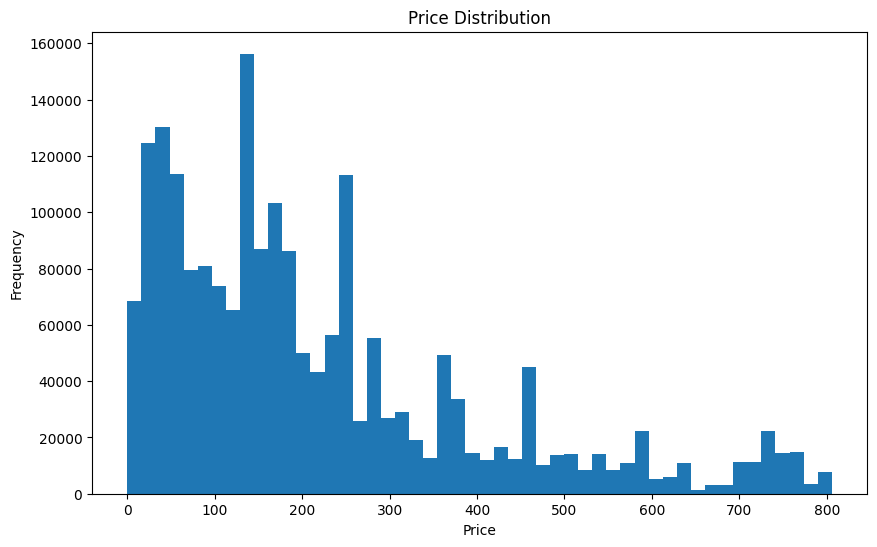

In [35]:
import numpy as np

counts, bins = np.histogram(df['price'].dropna(), bins=50)
plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['price'] = scaler.fit_transform(df[['price']])

print(df['price'].head())

0   -0.621586
1   -1.007712
2   -1.002149
3    1.465624
4   -0.468302
Name: price, dtype: float64


C:\Users\malak\AppData\Local\Temp\ipykernel_9760\2341144803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = scaler.fit_transform(df[['price']])


In [37]:
df.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:13 UTC,2,3900746,2053013552326770905,-0.621586,555444559,98b88fa0-d8fa-4b9d-8a71-3dd403afab85,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:36 UTC,2,12712064,2053013553559896355,-1.007712,515454339,828dbd8e-8683-409b-aef6-6a94ac983b45,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:01:21 UTC,2,28708392,2053013565069067197,-1.002149,555447570,99877fbe-d5a8-475e-a662-66bc9d29b6f8,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:01:26 UTC,2,15100008,2053013557024391671,1.465624,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:02:14 UTC,1,1004856,2053013555631882655,-0.468302,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2001405 entries, 0 to 2228546
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   event_time       object 
 1   event_type       int32  
 2   product_id       int64  
 3   category_id      int64  
 4   price            float64
 5   user_id          int64  
 6   user_session     object 
 7   category_code_0  int64  
 8   category_code_1  int64  
 9   category_code_2  int64  
 10  category_code_3  int64  
 11  category_code_4  int64  
 12  category_code_5  int64  
 13  category_code_6  int64  
 14  brand_0          int64  
 15  brand_1          int64  
 16  brand_2          int64  
 17  brand_3          int64  
 18  brand_4          int64  
 19  brand_5          int64  
 20  brand_6          int64  
 21  brand_7          int64  
 22  brand_8          int64  
 23  brand_9          int64  
 24  brand_10         int64  
 25  brand_11         int64  
dtypes: float64(1), int32(1), int64(22), object(2)
m

In [39]:
df.shape

(2001405, 26)

In [40]:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)
df.set_index('event_time', inplace=True)

C:\Users\malak\AppData\Local\Temp\ipykernel_9760\4276349513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_time'] = pd.to_datetime(df['event_time'], utc=True)


In [ ]:
df.dtypes

event_type           int32
product_id           int64
category_id          int64
price              float64
user_id              int64
user_session        object
category_code_0      int64
category_code_1      int64
category_code_2      int64
category_code_3      int64
category_code_4      int64
category_code_5      int64
category_code_6      int64
brand_0              int64
brand_1              int64
brand_2              int64
brand_3              int64
brand_4              int64
brand_5              int64
brand_6              int64
brand_7              int64
brand_8              int64
brand_9              int64
brand_10             int64
brand_11             int64
dtype: object

In [ ]:
print(df.columns)

Index(['event_type', 'product_id', 'category_id', 'price', 'user_id',
       'user_session', 'category_code_0', 'category_code_1', 'category_code_2',
       'category_code_3', 'category_code_4', 'category_code_5',
       'category_code_6', 'brand_0', 'brand_1', 'brand_2', 'brand_3',
       'brand_4', 'brand_5', 'brand_6', 'brand_7', 'brand_8', 'brand_9',
       'brand_10', 'brand_11'],
      dtype='object')


In [49]:
# Final check
print("Final shape:", df.shape)
print("Remaining nulls:", df.isnull().sum().sum())

Final shape: (2001405, 25)
Remaining nulls: 1


In [50]:
print(df[df.isnull().any(axis=1)])  # show rows with nulls

# For example, if null is in features, you can:
df = df.dropna()  # or fillna with mean/median/mode if you prefer

# If it’s just one or a few rows, dropping might be simplest:
print("Remaining nulls:", df.isnull().sum().sum())


                           event_type  product_id          category_id  \
event_time                                                               
2019-10-25 10:36:14+00:00           0     1004767  2053013555631882655   

                              price    user_id user_session  category_code_0  \
event_time                                                                     
2019-10-25 10:36:14+00:00  0.156932  549825742          NaN                0   

                           category_code_1  category_code_2  category_code_3  \
event_time                                                                     
2019-10-25 10:36:14+00:00                0                0                0   

                           ...  brand_2  brand_3  brand_4  brand_5  brand_6  \
event_time                 ...                                                
2019-10-25 10:36:14+00:00  ...        0        0        0        0        0   

                           brand_7  brand_8  brand_9  bra

In [52]:
# Final check
print("Final shape:", df.shape)
print("Remaining nulls:", df.isnull().sum().sum())

Final shape: (2001404, 25)
Remaining nulls: 0


In [53]:
# Resample to get daily event counts
daily_events = df.resample('D').size()

In [54]:
# Compute 7-day rolling average for trend
rolling_avg = daily_events.rolling(window=7).mean()

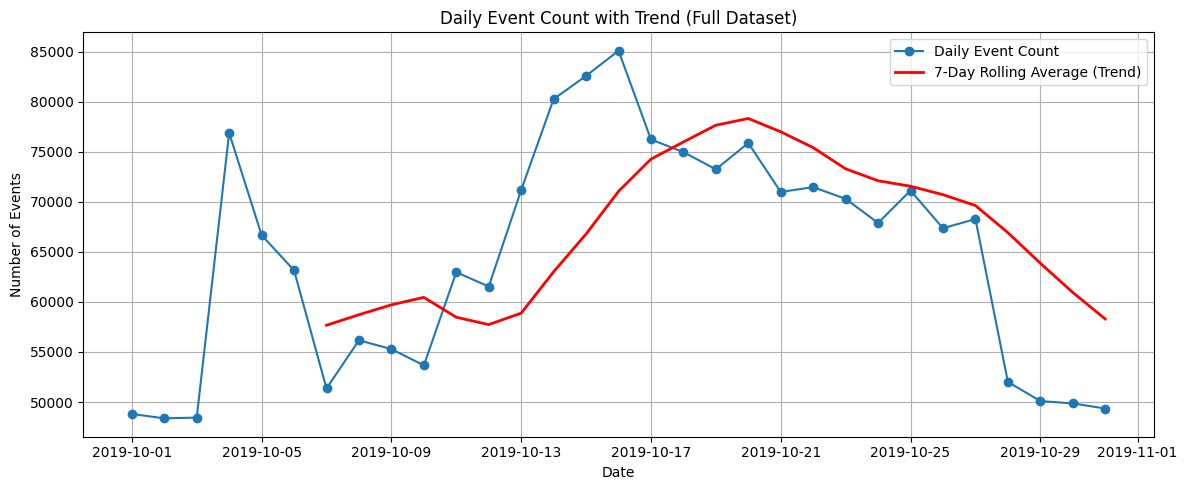

In [55]:
# Plot the result
plt.figure(figsize=(12, 5))
plt.plot(daily_events, label='Daily Event Count', marker='o')
plt.plot(rolling_avg, label='7-Day Rolling Average (Trend)', color='red', linewidth=2)
plt.title('Daily Event Count with Trend (Full Dataset)')
plt.ylabel('Number of Events')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

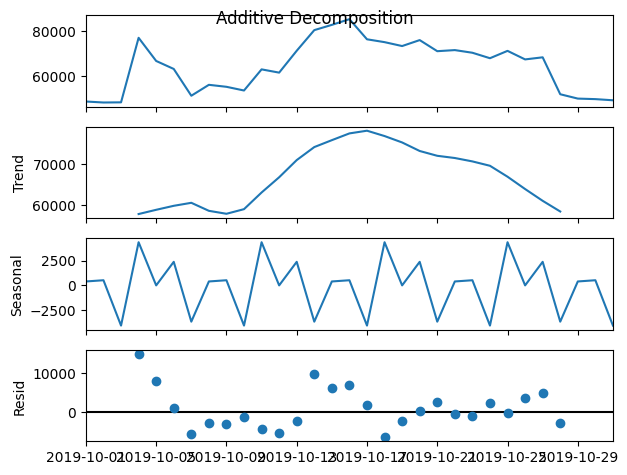

In [56]:
# Additive decomposition
result_add = seasonal_decompose(daily_events, model='additive', period=7)  # period=7 for weekly seasonality
result_add.plot()
plt.suptitle('Additive Decomposition')
plt.show()

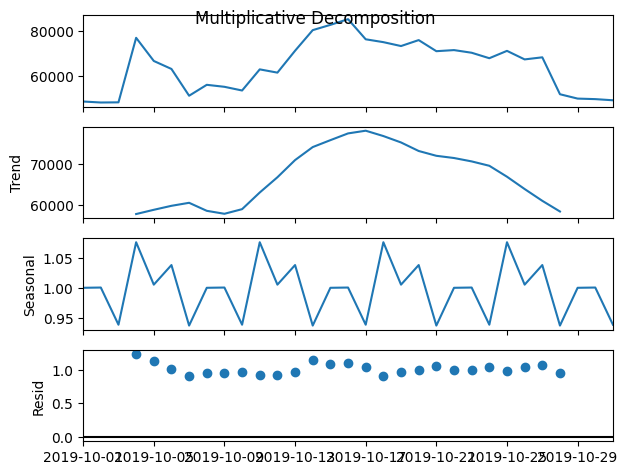

In [57]:
# Multiplicative decomposition
result_mul = seasonal_decompose(daily_events, model='multiplicative', period=7)
result_mul.plot()
plt.suptitle('Multiplicative Decomposition')
plt.show()

In [58]:
# Aggregate: count number of events per day
daily_events = df.groupby(df.index.date).size()
daily_events = daily_events.rename('event_count').to_frame()

In [59]:
# Perform ADF test on this daily event count series
result = adfuller(daily_events['event_count'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Critical values for significance levels
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

if result[1] < 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

ADF Statistic: -2.321314
p-value: 0.165186
Critical Value 1%: -3.6889256286443146
Critical Value 5%: -2.9719894897959187
Critical Value 10%: -2.6252957653061224
The series is not stationary


In [60]:
result_mul.trend.index = result_mul.trend.index.tz_localize(None)
detrended = daily_events['event_count'] / result_mul.trend

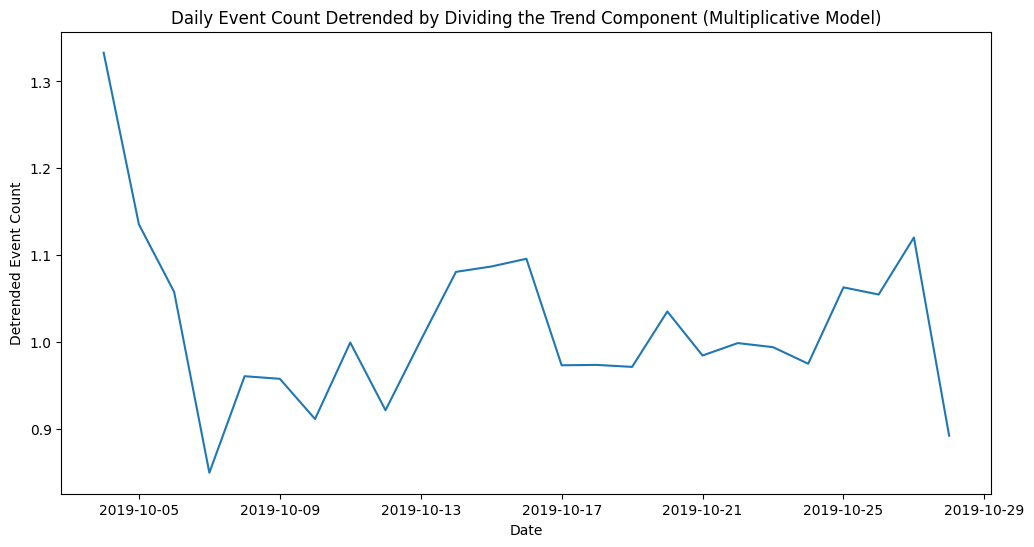

In [61]:
plt.figure(figsize=(12,6))
plt.plot(detrended)
plt.title('Daily Event Count Detrended by Dividing the Trend Component (Multiplicative Model)')
plt.xlabel('Date')
plt.ylabel('Detrended Event Count')
plt.show()

In [62]:
result_mul_seasonal = result_mul.seasonal.copy()
result_mul_seasonal.index = result_mul_seasonal.index.tz_localize(None)  # remove tz info

In [63]:
seasonally_adjusted = detrended / result_mul_seasonal

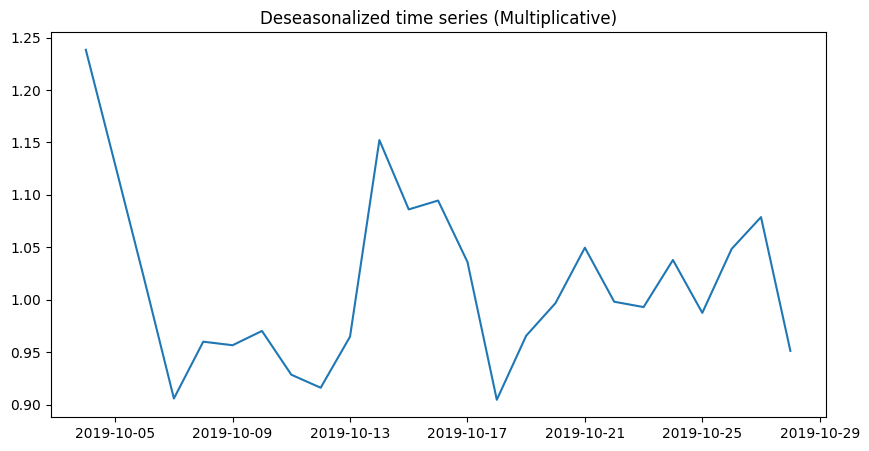

In [64]:
plt.figure(figsize=(10,5))
plt.plot(seasonally_adjusted)
plt.title('Deseasonalized time series (Multiplicative)')
plt.show()

In [65]:
result = adfuller(seasonally_adjusted.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('The deseasonalized series is stationary')
else:
    print('The deseasonalized series is not stationary')

ADF Statistic: -3.985117
p-value: 0.001490
The deseasonalized series is stationary


In [66]:
# Interpolate missing values in the deseasonalized series
seasonally_adjusted_filled = seasonally_adjusted.interpolate(method='linear')

# Double-check if any missing values remain
print(seasonally_adjusted_filled.isnull().sum())

3


In [67]:
seasonally_adjusted_filled = seasonally_adjusted_filled.dropna()
print(seasonally_adjusted_filled.isnull().sum())  # 0 now

0


In [68]:
print(len(seasonally_adjusted_filled))

28


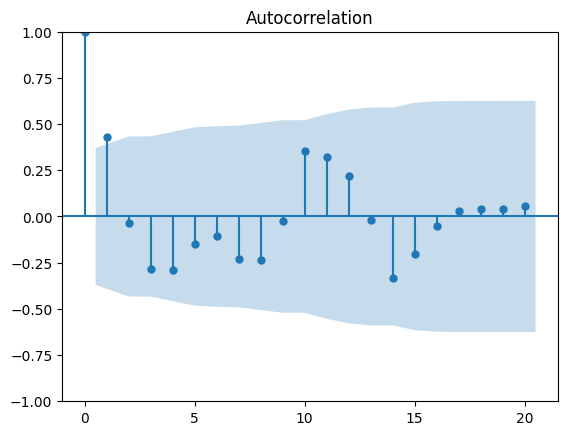

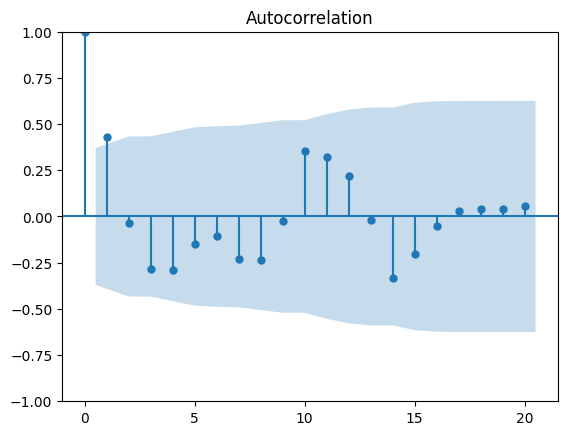

In [69]:
plot_acf(seasonally_adjusted_filled.dropna(), lags=20, ax=plt.gca())

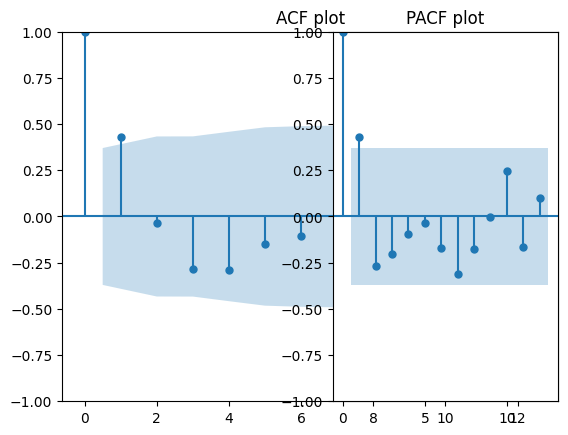

In [70]:
lags = 12  # less than 28/2
plot_acf(seasonally_adjusted_filled.dropna(), lags=lags, ax=plt.gca())
plt.title('ACF plot')

plt.subplot(1,2,2)
plot_pacf(seasonally_adjusted_filled.dropna(), lags=lags, ax=plt.gca())
plt.title('PACF plot')
plt.show()

In [71]:
df['event_type'].unique()

array([2, 1, 0])

In [72]:
# Save DataFrame to CSV
df.to_csv('Preprocessed Time Series Final(2).csv', index=False)